Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a CBOW model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


### Remove stop-words to reduce low information words within the corpus.

In [3]:
stopwords = ['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 'am', 
             'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 
             'but', 'by', 'can', 'cannot', 'could', 'dear', 'did', 'do', 'does', 
             'either', 'else', 'ever', 'every', 'for', 'from', 'get', 'got', 'had', 
             'has', 'have', 'he', 'her', 'hers', 'him', 'his', 'how', 'however', 'i', 
             'if', 'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 'like', 
             'likely', 'may', 'me', 'might', 'most', 'must', 'my', 'neither', 'no', 
             'nor', 'not', 'of', 'off', 'often', 'on', 'only', 'or', 'other', 'our', 
             'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since', 'so', 
             'some', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 
             'they', 'this', 'tis', 'to', 'too', 'twas', 'us', 'wants', 'was', 'we', 
             'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 
             'will', 'with', 'would', 'yet', 'you', 'your']

Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

rawWords = read_data(filename)
print('Data size %d' % len(rawWords))

words = []
for word in rawWords:
    if word not in stopwords:
        words.append(word)
        
print('Data size %d' % len(words))

Data size 17005207
Data size 11138468


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 417343], ('one', 411764), ('zero', 264975), ('nine', 250430), ('two', 192644)]
Sample data [5125, 2970, 122, 3023, 12, 17, 86, 60, 642, 387]


# Start of differences from Skipgram model.

Function to generate a training batch for the CBOW model.

In [24]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    # batch_size = total number of samples to return
    # num_skips = number of context words to return per label
    # skip_window = distance from the label of the farthest context word to return
  global data_index                             # Pull in global index to keep from repeating data between batches
  assert batch_size % num_skips == 0            # Ensure the total batch divides evenly by context words per label           
  assert num_skips <= 2 * skip_window           # Ensure num_skips fits in full skip_window
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)           # Create batch container
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)       # Create label container
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]  # Define full skip_window
  buffer = collections.deque(maxlen=span)       # Define buffer to be loaded with words, limited to span length
  for _ in range(span):                         # Loop span times
    buffer.append(data[data_index])             # Add the next word to the buffer
    data_index = (data_index + 1) % len(data)   # Add 1 to the counter, if it overflows the dataset, reset counter to 0
  for i in range(batch_size):                   # Loop once per label
    target = skip_window                        # Mark the center element in buffer as the target label
    targets_to_avoid = [ skip_window ]          # Avoid adding the label to the context words
    labels[i, 0] = buffer[skip_window]  # Write labels to labels
    for j in range(num_skips):                # Loop once per context word for the current label
      while target in targets_to_avoid:         # While the current word is already in the avoid list
        target = random.randint(0, span - 1)    # Pick a different word
      targets_to_avoid.append(target)           # Add the new word to the avoid list
      batch[i, j] = buffer[target]              # Write context words to batch
    buffer.append(data[data_index])             # After each label, add a word to the end of the buffer, dropping the first word
    data_index = (data_index + 1) % len(data)   # Increment the global index
  return batch, labels                          # Return the batch and labels arrays

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(8*num_skips)])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'against', 'early']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'term', 'abuse', 'originated', 'term', 'first', 'abuse', 'used', 'against', 'first', 'early', 'used', 'working', 'against', 'early', 'class']
    labels: ['originated', 'term', 'abuse', 'first', 'used', 'against', 'early', 'working']

with num_skips = 4 and skip_window = 2:
    batch: ['first', 'abuse', 'anarchism', 'originated', 'used', 'originated', 'term', 'first', 'term', 'used', 'against', 'abuse', 'against', 'abuse', 'first', 'early', 'first', 'working', 'used', 'early', 'against', 'class', 'working', 'used', 'early', 'radicals', 'against', 'class', 'working', 'early', 'radicals', 'including']
    labels: ['term', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class']


Train a CBOW model.

In [43]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 4 # How many words to consider left and right.
span = (skip_window * 2) + 1
num_skips = 4 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_targets = np.ndarray((valid_size, span))
for i, example in enumerate(valid_examples):
    for j in range(span):
        valid_targets[i, j] = data[example + j]    

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.                                        # Create context, label and validation placeholders
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_targets, dtype=tf.int32)
  
  # Variables.                                         # Create tunable varaibles to map contexts vectors
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs then sum row for each label.
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset), axis=1)

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.reduce_sum(tf.nn.embedding_lookup(normalized_embeddings, valid_dataset), axis=1)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [44]:
print(valid_targets.shape)

(16, 9)


In [45]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:                                   # Every 2000 steps measure loss rate
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:                                  # Every 10,000 steps display vector samples
      sim = similarity.eval()                              # Use defined similarity from previous cell
      for i in range(valid_targets.shape[0]):                        # Loop valid_size times (number of test words)
        phrase_length = valid_targets.shape[1] 
        phrase_sum = 0
        phrase = []
        label = ''
        for j in range(phrase_length):
            if j != ((phrase_length // 2) + 1): 
                phrase.append(reverse_dictionary[valid_targets[i, j]])
            else:
                label = reverse_dictionary[valid_targets[i, j]]
#        valid_word = reverse_dictionary[valid_examples[i]] # find the word represented by valid_examples[i]
#        top_k = 8 # number of nearest neighbors            # define breadth of the KNN test
#        nearest = (-sim[i, :]).argsort()[1:top_k+1]        # find the KNN examples
        log = 'Missing word in'
        for word in phrase:
          log += ' ' + word
        
        pred = reverse_dictionary[(-sim[i, :]).argsort()[0]]        # find the KNN examples
#        log = 'Nearest to %s:' % valid_word                # Start building output string
#        for k in range(top_k):                             # Loop K times (from KNN)
#          close_word = reverse_dictionary[nearest[k]]      # Find the context word represented by each vector
#          log = '%s %s,' % (log, close_word)               # add info to output string
        print(log)
        print('Truth: ', label, ' Pred: ', pred)     # print output string
  final_embeddings = normalized_embeddings.eval()          # Normalize embeddings using formula from the previous cell

Initialized
Average loss at step 0: 7.670998
Missing word in institutions particularly state word anarchy use imply chaos
Truth:  anarchists  Pred:  institutions
Missing word in philosophy belief rulers unnecessary abolished differing interpretations means
Truth:  although  Pred:  interpretations
Missing word in french revolution whilst term still pejorative way describe
Truth:  used  Pred:  used
Missing word in destroy organization society taken up label self defined
Truth:  positive  Pred:  taken
Missing word in taken up positive label self anarchists word anarchism
Truth:  defined  Pred:  taken
Missing word in anarchists advocate social relations based voluntary association autonomous
Truth:  upon  Pred:  autonomous
Missing word in based upon voluntary association autonomous mutual aid self
Truth:  individuals  Pred:  autonomous
Missing word in anarchists use imply chaos nihilism harmonious anti authoritarian
Truth:  UNK  Pred:  UNK
Missing word in anarchism political philosophy bel

In [46]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

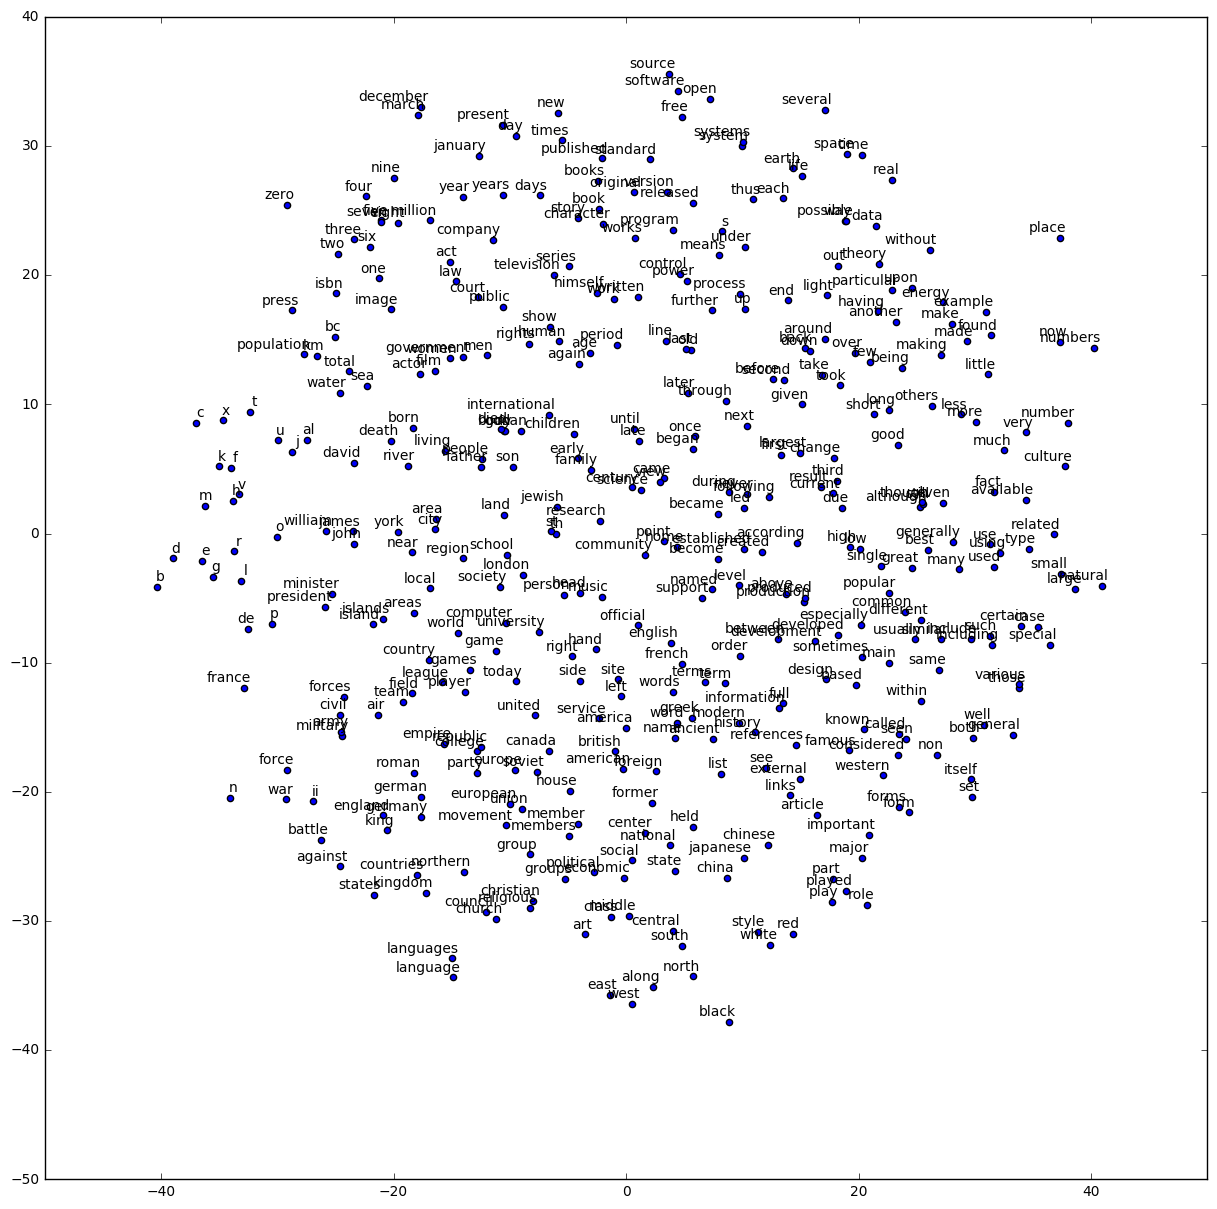

In [47]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---